# Step 2-1 Baseline ARIMA

# Baseline ARIMA model

**ARIMA workflow**:
ADF test to check stationarity (p_value < 0.05) -> ACF, PACF testing to determine p, q -> Gridsearch to determine the optimal order (AIC)

-> Auto ARIMA search -> model comparison (Baseline(1, 1, 1), Manual Grid Search, Auto ARIMA (fixed d), Auto ARIMA (free d))

**Forecast workflow**:
train data for each country -> train ARIMA once -> fit the model -> predict each test year individually

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import itertools
import os
import warnings

warnings.filterwarnings("ignore")

In [2]:
TARGET_VARIABLES = 'co2'
SELECTED_COUNTRIES = ['United States', 'China', 'India']
G7_COUNTRIES = ['United States', 'China', 'India', 'Canada', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom']
G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]
TEST_SIZE = 9
MAX_LAGS = 4

save_dir = 'data/02_01_results'
os.makedirs(save_dir, exist_ok=True)

"""
# ENERGY_MIX columns in this dataframe

Total Energy = Fossil + Low_carbon
Fossil = coal + oil + gas
Low_carbon = nuclear + Renewables
Renwables = biofuel + solar + hydro + wind + other_renewables
"""

# Categories for the variables
# The total sum for each category should be excluded

# Using this hhi would be better since including all detailed columns would be granular?
TOTAL_PROPORTIONS = [
    'fossil_share_energy',
    'low_carbon_share_energy'
]

FOSSIL_PROPORTIONS = [
    #'fossil_share_energy',
    'coal_share_energy',
    'oil_share_energy',
    'gas_share_energy'
]

LOW_CARBON_PROPORTIONS = [
    'nuclear_share_energy',
    #'renewables_share_energy', # This renewables share is the total share of primary energy from all (including solar, ...)
    'biofuel_share_energy',
    'solar_share_energy',
    'wind_share_energy',
    'hydro_share_energy',
    'other_renewables_share_energy'
]

DETAILED_PROPORTIONS = FOSSIL_PROPORTIONS + LOW_CARBON_PROPORTIONS

In [3]:
def load_data(save_dir='data'):
    data_files = {
        'lag_df': os.path.join(save_dir, 'lag_df.csv'),
        'g7_lag_df': os.path.join(save_dir, 'g7_lag_df.csv'),
        'g20_lag_df': os.path.join(save_dir, 'g20_lag_df.csv'),
        'lag_three_sel_1969_df': os.path.join(save_dir, 'lag_three_sel_1969_df.csv'),
        'three_interpolated_df': os.path.join(save_dir, 'three_interpolated_df.csv'),
        'g7_interpolated_df': os.path.join(save_dir, 'g7_interpolated_df.csv'),
        'g20_interpolated_df': os.path.join(save_dir, 'g20_interpolated_df.csv'),
        'all_interpolated_df': os.path.join(save_dir, 'all_interpolated_df.csv')
    }

    dfs = {}
    for name, filepath in data_files.items():
        if os.path.exists(filepath):
            dfs[name] = pd.read_csv(filepath)
            print(f"Loaded {name}: {dfs[name].shape}")
        else:
            print(f"{filepath} not found")
    
    return dfs

In [4]:
data = load_data()

lag_df = data['lag_df']
lag_1969_df = lag_df[lag_df['year'] >= 1969].copy()
lag_1969_df = lag_1969_df[lag_1969_df['year'] < 2023]

g7_lag_df = data['g7_lag_df']
g7_lag_1969_df = g7_lag_df[g7_lag_df['year'] >= 1969].copy()
g7_lag_1969_df = g7_lag_1969_df[g7_lag_1969_df['year'] < 2023]

g20_lag_df = data['g20_lag_df']
g20_lag_1969_df = g20_lag_df[g20_lag_df['year'] >= 1969].copy()
g20_lag_1969_df = g20_lag_1969_df[g20_lag_1969_df['year'] < 2023]

lag_three_sel_1969_df = data['lag_three_sel_1969_df']

three_interpolated_df = data['three_interpolated_df']
g7_interpolated_df = data['g7_interpolated_df']
g20_interpolated_df = data['g20_interpolated_df']
all_interpolated_df = data['all_interpolated_df']

Loaded lag_df: (55529, 992)
Loaded g7_lag_df: (1890, 992)
Loaded g20_lag_df: (3744, 992)
Loaded lag_three_sel_1969_df: (162, 992)
Loaded three_interpolated_df: (135, 992)
Loaded g7_interpolated_df: (405, 992)
Loaded g20_interpolated_df: (855, 992)
Loaded all_interpolated_df: (9090, 992)


In [5]:
# train_test_split
def tts_ARIMA_by_year(interpolated_df, full_df, countries, test_size=TEST_SIZE):
    train_data = {}
    test_data = {}

    for country in countries:
        country_train = interpolated_df[interpolated_df['country'] == country].sort_values('year').copy()

        country_full = full_df[full_df['country'] == country].sort_values('year').copy()
        split_idx = len(country_full) - test_size
        country_test = country_full.iloc[split_idx:].copy()

        train_data[country] = country_train
        test_data[country] = country_test

        print(f"\n{country}:")
        print(f"    Train: {len(country_train)} samples, years {country_train['year'].min()}-{country_train['year'].max()}")
        print(f"    Test:  {len(country_test)} samples, years {country_test['year'].min()}-{country_test['year'].max()}")

    train_df = pd.concat(train_data.values(), ignore_index=True)
    test_df = pd.concat(test_data.values(), ignore_index=True)

    return train_df, test_df

In [6]:
three_train_df, three_test_df = tts_ARIMA_by_year(
    three_interpolated_df, lag_three_sel_1969_df, SELECTED_COUNTRIES
)


United States:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

China:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022

India:
    Train: 45 samples, years 1969-2013
    Test:  9 samples, years 2014-2022


In [7]:
def mase(y_actual, y_pred, period=1):
    mae_forecast = mean_absolute_error(y_actual, y_pred)

    naive_forecast = y_actual[:-period] if period > 0 else y_actual[:-1]
    actual_for_naive = y_actual[period:] if period > 0 else y_actual[1:]

    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)

    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

## ARIMA

### ADF Test
ADF Test with AIC to determine differencing order

In [8]:
def adf_test(series, name='Series'):
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n{name} :")
    print(f"    ADF Stats: {result[0]:.4f}")
    print(f"    p-value: {result[1]:.4f}")
    print(f"    Lags Used: {result[2]}")
    print(f"    Observations: {result[3]}")

    is_stationary = result[1] < 0.05

    if is_stationary:
        print(f"    Series is stationary (p_val < 0.05), d = 0")
    else:
        print(f"    Series not stationary (p_val >= 0.05), d > 0")

    return is_stationary, result

In [9]:
stationarity_results = {}

for country in SELECTED_COUNTRIES:
    print(f"\n{country.upper()}")

    train_country = three_train_df[three_train_df['country'] == country].sort_values('year')
    series = train_country[TARGET_VARIABLES]

    # Test on original
    is_stationary_0, result_0 = adf_test(series, f'{country} - {TARGET_VARIABLES} (Original)')
    stationarity_results[country] = {'d=0': {'stationary': is_stationary_0, 'p_value': result_0[1]}}

    # Test further if not stationary
    if not is_stationary_0:
        series_diff1 = series.diff().dropna()
        is_stationary_1, result_1 = adf_test(series_diff1, f'{country} - {TARGET_VARIABLES} (1st diff)')
        
        stationarity_results[country]['d=1'] = {'stationary': is_stationary_1, 'p_value': result_1[1]}

        if not is_stationary_1:
            series_diff2 = series_diff1.diff().dropna()
            is_stationary_2, result_2 = adf_test(series_diff2, f'{country} - {TARGET_VARIABLES} (2nd diff)')
            
            stationarity_results[country]['d=2'] = {'stationary': is_stationary_2, 'p_value': result_2[1]}

            if not is_stationary_2:
                series_diff3 = series_diff2.diff().dropna()
                is_stationary_3, result_3 = adf_test(series_diff3, f'{country} - {TARGET_VARIABLES} (3rd diff)')

                if not is_stationary_3:
                    series_diff4 = series_diff3.diff().dropna()
                    is_stationary_4, result_4 = adf_test(series_diff4, f'{country} - {TARGET_VARIABLES} (4th diff)')



UNITED STATES

United States - co2 (Original) :
    ADF Stats: -2.0233
    p-value: 0.2765
    Lags Used: 0
    Observations: 44
    Series not stationary (p_val >= 0.05), d > 0

United States - co2 (1st diff) :
    ADF Stats: -2.9753
    p-value: 0.0373
    Lags Used: 2
    Observations: 41
    Series is stationary (p_val < 0.05), d = 0

CHINA

China - co2 (Original) :
    ADF Stats: 1.7145
    p-value: 0.9982
    Lags Used: 10
    Observations: 34
    Series not stationary (p_val >= 0.05), d > 0

China - co2 (1st diff) :
    ADF Stats: -2.5640
    p-value: 0.1007
    Lags Used: 9
    Observations: 34
    Series not stationary (p_val >= 0.05), d > 0

China - co2 (2nd diff) :
    ADF Stats: -2.0645
    p-value: 0.2590
    Lags Used: 9
    Observations: 33
    Series not stationary (p_val >= 0.05), d > 0

China - co2 (3rd diff) :
    ADF Stats: -2.0437
    p-value: 0.2677
    Lags Used: 9
    Observations: 32
    Series not stationary (p_val >= 0.05), d > 0

China - co2 (4th diff) :
  

differencing order

* US = 1

* China = 4

* India = 2

### ACF and PACF
PACF to determine q: size of moving avg window

ACF to determine p: AR order (num of lag obs to include)

In [10]:
def plot_acf_pacf(df, target=TARGET_VARIABLES, save_dir='data/02_01_results'):
    os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(3, 2, figsize=(16,12))

    for idx, country in enumerate(SELECTED_COUNTRIES):
        train_country = df[df['country'] == country].sort_values('year')
        series = train_country[target]

        if country == 'United States':
            d = 1
        elif country == 'China':
            d = 4
        else:
            d = 2

        # ACF
        ax_acf = axes[idx, 0]
        plot_acf(series, lags=20, ax=ax_acf, alpha=0.05)
        ax_acf.set_title(f'{country}: ACF to determine q', fontsize=11, fontweight='bold')
        ax_acf.set_xlabel('Lag', fontsize=10)
        ax_acf.set_ylabel('Autocorrelation', fontsize=10)

        # PACF
        ax_pacf = axes[idx, 1]
        plot_pacf(series, lags=20, ax=ax_pacf, method='ywm', alpha=0.05)
        ax_pacf.set_title(f'{country}: PACF to determine p', fontsize=11, fontweight='bold')
        ax_pacf.set_xlabel('Lag', fontsize=10)
        ax_pacf.set_ylabel('Partial Autocorrleation', fontsize=10)

    plt.suptitle('ACF and PACF for ARIMA Parameter Selection', fontsize=13, fontweight='bold')
    plt.tight_layout()

    plot_path = os.path.join(save_dir, 'acf_pacf_3countries.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()

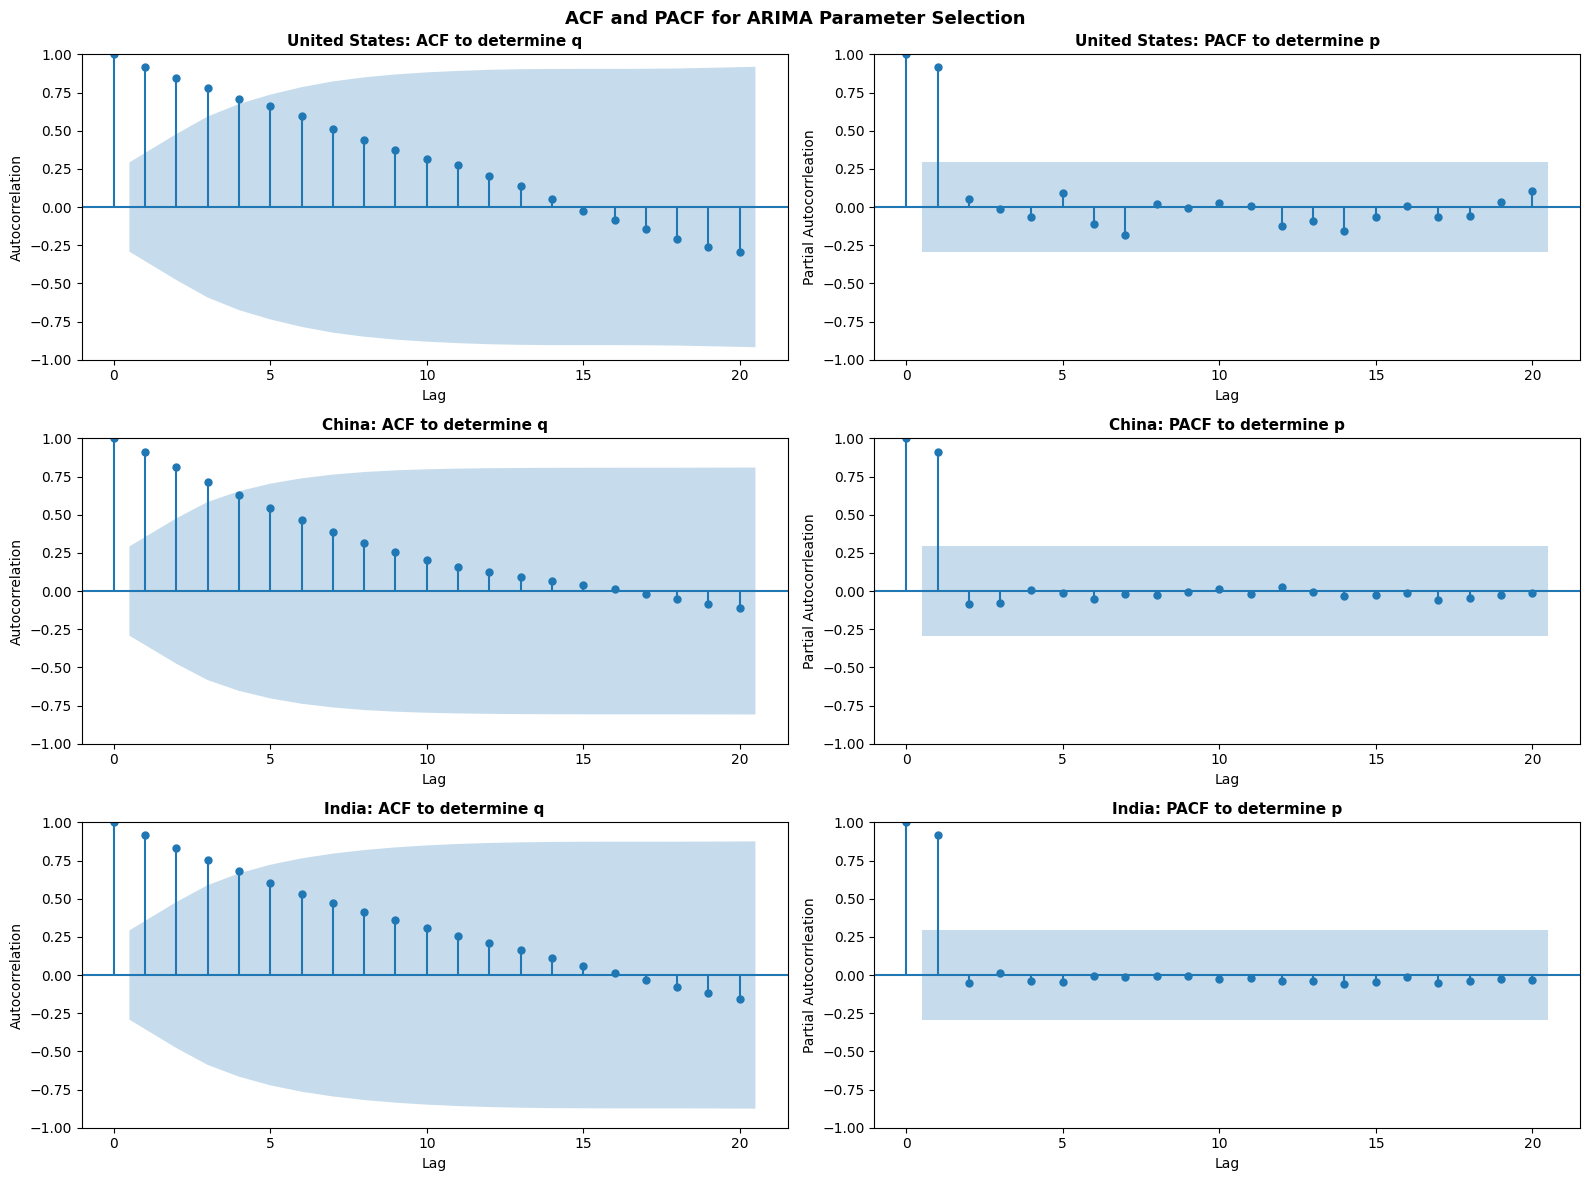

In [11]:
plot_acf_pacf(three_train_df)

shaded blue area is where not significant for 95% CI

(p, q) orders

* US = (1, 0)

* China = (1, 0)

* India = (1, 0)

### Grid Search

Grid search to find the optimal (p, d, q) comb

And choose the best order by AIC

In [12]:
def grid_search(train, target=TARGET_VARIABLES, p_range=range(0, 3), d_range=range(0, 3), q_range=range(0, 2)):
    results = []

    pdq_comb = list(itertools.product(p_range, d_range, q_range))

    for pdq in pdq_comb:
        try:
            model = ARIMA(train[target].values, order=pdq)
            fitted_model = model.fit()

            results.append({
                'p': pdq[0],
                'd': pdq[1],
                'q': pdq[2],
                'order': pdq,
                'AIC': fitted_model.aic,
                'BIC': fitted_model.bic,
                'Log-Likelihood': fitted_model.llf
            })
        except:
            continue

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('AIC').reset_index(drop=True)
    
    best_order = results_df.iloc[0]['order']
    
    return results_df, best_order

In [13]:
optimal_orders = {}

for country in SELECTED_COUNTRIES:
    print(f"\n{country.upper()}")

    train_country = three_train_df[three_train_df['country'] == country].sort_values('year')

    results_df, best_order = grid_search(train_country)

    optimal_orders[country] = best_order

    print(f"\n Top 5 models by AIC:")
    print(results_df.head().to_string(index=False))

    print(f"\n Best Order: {best_order}")
    print(f"    AIC: {results_df.iloc[0]['AIC']:.4f}")
    print(f"    BIC: {results_df.iloc[0]['BIC']:.4f}")


UNITED STATES

 Top 5 models by AIC:
 p  d  q     order        AIC        BIC  Log-Likelihood
 2  2  0 (2, 2, 0) 564.005485 569.289085     -279.002742
 0  2  1 (0, 2, 1) 565.487701 569.010101     -280.743851
 2  2  1 (2, 2, 1) 566.004016 573.048817     -279.002008
 1  2  1 (1, 2, 1) 566.897975 572.181575     -280.448988
 1  1  1 (1, 1, 1) 571.860641 577.213210     -282.930321

 Best Order: (2, 2, 0)
    AIC: 564.0055
    BIC: 569.2891

CHINA

 Top 5 models by AIC:
 p  d  q     order        AIC        BIC  Log-Likelihood
 2  2  0 (2, 2, 0) 566.139095 571.422695     -280.069547
 2  2  1 (2, 2, 1) 568.102151 575.146951     -280.051075
 1  2  1 (1, 2, 1) 568.131790 573.415391     -281.065895
 0  2  1 (0, 2, 1) 568.203834 571.726234     -282.101917
 0  2  0 (0, 2, 0) 570.449985 572.211185     -284.224993

 Best Order: (2, 2, 0)
    AIC: 566.1391
    BIC: 571.4227

INDIA

 Top 5 models by AIC:
 p  d  q     order        AIC        BIC  Log-Likelihood
 2  2  0 (2, 2, 0) 391.230803 396.514403 

### Forecast

Forecasting with its best order

In [14]:
def forecast_with_order(train, test, order, target=TARGET_VARIABLES):
    train_sorted = train.sort_values('year')
    test_sorted = test.sort_values('year')
    
    model = ARIMA(train_sorted[target].values, order=order)
    fitted_model = model.fit()
    
    forecast = fitted_model.forecast(steps=len(test_sorted))
    
    return forecast, fitted_model

In [15]:
comparison_results = {}

for country in SELECTED_COUNTRIES:
    print(f"\n{country.upper()}")

    train_country = three_train_df[three_train_df['country'] == country]
    test_country = three_test_df[three_test_df['country'] == country]
    y_test = test_country.sort_values('year')[TARGET_VARIABLES].values

    # Baseline order (1, 1, 1)
    forecast_baseline, _ = forecast_with_order(train_country, test_country, (1,1,1))
    rmse_baseline = np.sqrt(mean_squared_error(y_test, forecast_baseline))
    mae_baseline = mean_absolute_error(y_test, forecast_baseline)

    # Optimal order
    optimal_order = optimal_orders[country]
    forecast_optimal, _ = forecast_with_order(train_country, test_country, optimal_order)
    rmse_optimal = np.sqrt(mean_squared_error(y_test, forecast_optimal))
    mae_optimal = mean_absolute_error(y_test, forecast_optimal)

    comparison_results[country] = {
        'Baseline order': {'RMSE': rmse_baseline, 'MAE': mae_baseline},
        'Optimal order': {'RMSE': rmse_optimal, 'MAE': mae_optimal}
    }

    print(f"  Baseline Order:")
    print(f"    RMSE: {rmse_baseline:.2f}, MAE: {mae_baseline:.2f}")
    print(f"  Optimal {optimal_order}:")
    print(f"    RMSE: {rmse_optimal:.2f}, MAE: {mae_optimal:.2f}")



UNITED STATES
  Baseline Order:
    RMSE: 368.40, MAE: 298.16
  Optimal (2, 2, 0):
    RMSE: 226.80, MAE: 158.13

CHINA
  Baseline Order:
    RMSE: 497.84, MAE: 426.66
  Optimal (2, 2, 0):
    RMSE: 1542.25, MAE: 1474.88

INDIA
  Baseline Order:
    RMSE: 99.10, MAE: 79.60
  Optimal (2, 2, 0):
    RMSE: 120.62, MAE: 84.76


### Auto ARIMA

In [16]:
from pmdarima import auto_arima

def auto_arima_search(train, country, target=TARGET_VARIABLES, fix_d=True):
    
    # Use d values from ADF test
    d_map = {
        'United States': 1,
        'China': 4,
        'India': 2
    }
    
    train_sorted = train.sort_values('year')
    
    # For China, try multiple d values since 4 is high
    if country == 'China' and fix_d:
        d_range = [1, 2, 4]
    else:
        d_range = [d_map[country]] if fix_d else None
    
    best_model = None
    best_order = None
    best_aic = np.inf
    
    # If testing multiple d values for China
    if country == 'China' and fix_d:
        print(f"\n  Testing multiple d values for {country}")
        for d_test in d_range:
            try:
                model = auto_arima(
                    train_sorted[target].values,
                    d=d_test,
                    start_p=0, max_p=3,
                    start_q=0, max_q=5,
                    seasonal=False,
                    stepwise=True,
                    suppress_warnings=True,
                    error_action='ignore',
                    information_criterion='bic',
                    trace=False
                )
                
                print(f"    d={d_test}: Order {model.order}, BIC={model.bic():.2f}")
                
                if model.bic() < best_aic:
                    best_aic = model.bic()
                    best_model = model
                    best_order = model.order
            except:
                print(f"    d={d_test}: Failed to fit")
                continue
    else:
        # Standard auto_arima
        d_value = d_map[country] if fix_d else None
        
        model = auto_arima(
            train_sorted[target].values,
            d=d_value,
            start_p=0, max_p=3,
            start_q=0, max_q=5,
            seasonal=False,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            information_criterion='aic',
            trace=False
        )
        
        best_model = model
        best_order = model.order
    
    return best_order, best_model

In [17]:
# Compare models with Baseline
def compare_models(train, test, target=TARGET_VARIABLES):

    train_sorted = train.sort_values('year')
    test_sorted = test.sort_values('year')
    y_test = test_sorted[target].values
    
    results = {}
    
    # Baseline (1,1,1)
    try:
        forecast_baseline, fitted_baseline = forecast_with_order(train, test, (1,1,1))
        results['Baseline (1,1,1)'] = {
            'RMSE': np.sqrt(mean_squared_error(y_test, forecast_baseline)),
            'MAE': mean_absolute_error(y_test, forecast_baseline),
            'order': (1, 1, 1),
            'AIC': fitted_baseline.aic,
            'BIC': fitted_baseline.bic
        }
    except Exception as e:
        results['Baseline (1,1,1)'] = {'error': str(e)}
    
    return results

In [18]:
print("AUTO ARIMA RESULTS")

auto_arima_orders = {}
all_results = {}

for country in SELECTED_COUNTRIES:
    print(f"\n{country.upper()}")
    
    train_country = three_train_df[three_train_df['country'] == country]
    test_country = three_test_df[three_test_df['country'] == country]
    y_test = test_country.sort_values('year')[TARGET_VARIABLES].values
    
    # Baseline results
    results = compare_models(train_country, test_country)
    
    # Auto ARIMA with fixed d
    print("\nAuto ARIMA (with informed d from ADF test):")
    auto_order_fixed, auto_model_fixed = auto_arima_search(
        train_country, country, fix_d=True
    )
    forecast_auto_fixed, _ = forecast_with_order(
        train_country, test_country, auto_order_fixed
    )
    results['Auto ARIMA (fixed d)'] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, forecast_auto_fixed)),
        'MAE': mean_absolute_error(y_test, forecast_auto_fixed),
        'order': auto_order_fixed,
        'AIC': auto_model_fixed.aic(),
        'BIC': auto_model_fixed.bic()
    }
    print(f"  Selected Order: {auto_order_fixed}")
    print(f"  AIC: {auto_model_fixed.aic():.2f}")
    
    # Auto ARIMA freeing d
    print("\nAuto ARIMA (free d):")
    auto_order_free, auto_model_free = auto_arima_search(
        train_country, country, fix_d=False
    )
    forecast_auto_free, _ = forecast_with_order(
        train_country, test_country, auto_order_free
    )
    results['Auto ARIMA (free d)'] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, forecast_auto_free)),
        'MAE': mean_absolute_error(y_test, forecast_auto_free),
        'order': auto_order_free,
        'AIC': auto_model_free.aic(),
        'BIC': auto_model_free.bic()
    }
    print(f"  Selected Order: {auto_order_free}")
    print(f"  AIC: {auto_model_free.aic():.2f}")
    
    # Manual optimal order from grid search
    manual_optimal = optimal_orders[country]
    try:
        forecast_manual, fitted_manual = forecast_with_order(train_country, test_country, manual_optimal)

        results['Manual Grid Search'] = {
            'RMSE': np.sqrt(mean_squared_error(y_test, forecast_manual)),
            'MAE': mean_absolute_error(y_test, forecast_manual),
            'order': manual_optimal,
            'AIC':fitted_manual.aic,
            'BIC': fitted_manual.bic
        }
    except Exception as e:
        results['Manual Grid Search'] = {'error': str(e)}
    
    all_results[country] = results
    auto_arima_orders[country] = auto_order_fixed
    
    print("\nPERFORMANCE COMPARISON ON TEST SET:")
    print(f"{'Method':<30} {'Order':<15} {'RMSE':<12} {'MAE':<12}")
    
    for method, metrics in results.items():
        if 'error' not in metrics:
            order_str = str(metrics['order'])
            print(f"{method:<30} {order_str:<15} {metrics['RMSE']:>10.4f}  {metrics['MAE']:>10.4f}")
    
    # Best model
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    if valid_results:
        best_method = min(valid_results.items(), key=lambda x: x[1]['RMSE'])
        print(f"\nBest Model: {best_method[0]}")
        print(f"    Order: {best_method[1]['order']}")
        print(f"    RMSE: {best_method[1]['RMSE']:.2f}")
        print(f"    MAE: {best_method[1]['MAE']:.2f}")

AUTO ARIMA RESULTS

UNITED STATES

Auto ARIMA (with informed d from ADF test):
  Selected Order: (1, 1, 1)
  AIC: 571.86

Auto ARIMA (free d):
  Selected Order: (1, 1, 1)
  AIC: 571.86

PERFORMANCE COMPARISON ON TEST SET:
Method                         Order           RMSE         MAE         
Baseline (1,1,1)               (1, 1, 1)         368.3954    298.1649
Auto ARIMA (fixed d)           (1, 1, 1)         368.3954    298.1649
Auto ARIMA (free d)            (1, 1, 1)         368.3954    298.1649
Manual Grid Search             (2, 2, 0)         226.7962    158.1328

Best Model: Manual Grid Search
    Order: (2, 2, 0)
    RMSE: 226.80
    MAE: 158.13

CHINA

Auto ARIMA (with informed d from ADF test):

  Testing multiple d values for China
    d=1: Order (1, 1, 0), BIC=585.43
    d=2: Order (0, 2, 0), BIC=572.21
    d=4: Order (3, 4, 0), BIC=584.18
  Selected Order: (0, 2, 0)
  AIC: 570.45

Auto ARIMA (free d):
  Selected Order: (0, 2, 2)
  AIC: 566.69

PERFORMANCE COMPARISON ON TEST

In [19]:
summary_data = []
for country in SELECTED_COUNTRIES:
    for method, metrics in all_results[country].items():
        if 'error' not in metrics:
            summary_data.append({
                'Country': country,
                'Method': method,
                'Order': str(metrics['order']),
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'AIC': metrics.get('AIC', np.nan),
                'BIC': metrics.get('BIC', np.nan)
            })

summary_df = pd.DataFrame(summary_data)
print("\nRMSE by Method (averaged across countries):")
print(summary_df.groupby('Method')['RMSE'].agg(['mean', 'std']).round(2))

print("\nBest performing method per country:")
for country in SELECTED_COUNTRIES:
    country_data = summary_df[summary_df['Country'] == country]
    best = country_data.loc[country_data['RMSE'].idxmin()]
    print(f"    {country}: {best['Method']} - Order {best['Order']}, RMSE={best['RMSE']:.4f}")


RMSE by Method (averaged across countries):
                        mean     std
Method                              
Auto ARIMA (fixed d)  301.60  171.25
Auto ARIMA (free d)   708.82  826.40
Baseline (1,1,1)      321.78  203.42
Manual Grid Search    629.89  791.91

Best performing method per country:
    United States: Manual Grid Search - Order (2, 2, 0), RMSE=226.7962
    China: Auto ARIMA (fixed d) - Order (0, 2, 0), RMSE=429.3823
    India: Baseline (1,1,1) - Order (1, 1, 1), RMSE=99.1002


In [20]:
save_dir = 'data/02_01_results'
md_path = os.path.join(save_dir, 'arima_method_summary.md')

with open(md_path, 'w') as f:
    f.write("# ARIMA Model Method Comparison\n\n")
    f.write("---\n\n")

    f.write("## Full Results by Country and Method\n\n")
    f.write(summary_df.to_markdown(index=False))
    f.write("\n\n")

    f.write("## RMSE by Method (Averaged Across Countries)\n\n")
    rmse_summary = summary_df.groupby('Method')['RMSE'].agg(['mean', 'std']).round(4)
    f.write(rmse_summary.to_markdown())
    f.write("\n\n")

    f.write("## Best Performing Method Per Country\n\n")
    for country in SELECTED_COUNTRIES:
        country_data = summary_df[summary_df['Country'] == country]
        best = country_data.loc[country_data['RMSE'].idxmin()]
        f.write(f"- **{country}** : {best['Method']} - Order {best['Order']}, RMSE={best['RMSE']:.4f}\n")
    f.write("\n")

In [21]:
best_orders = {
    'United States': (2, 2, 0),
    'China': (0, 2, 0),
    'India': (1, 1, 1)
}

results = {}
forecasts = {}

for country in SELECTED_COUNTRIES:
    print(f"\n{country.upper()}")

    train_country = three_train_df[three_train_df['country'] == country].sort_values('year')
    test_country = three_test_df[three_test_df['country'] == country].sort_values('year')

    order = best_orders[country]

    y_train = train_country[TARGET_VARIABLES].values
    model = ARIMA(y_train, order=order)
    fitted_model = model.fit()

    test_years = test_country['year'].values
    y_test = test_country[TARGET_VARIABLES].values

    forecast_values = []

    for i in range(len(test_country)):
        # Forecast one step ahead
        forecast_step = fitted_model.forecast(step=1)
        forecast_values.append(forecast_step[0])

        # Actual value for the following test year
        actual_value = y_test[i]

        # Append only on history but fixing the params
        fitted_model = fitted_model.append([actual_value])

    forecast_values = np.array(forecast_values)

    rmse = np.sqrt(mean_squared_error(y_test, forecast_values))
    mae = mean_absolute_error(y_test, forecast_values)
    naive_mae = np.mean(np.abs(np.diff(y_train)))
    mase = mae / naive_mae

    individual_errors = np.abs(y_test - forecast_values)

    results[country] = {
        'order': order,
        'RMSE': rmse,
        'MASE': mase,
        'forecast': forecast_values,
        'actual': y_test,
        'individual_errors': individual_errors,
        'test_years': test_years
    }

    forecasts[country] = {
        'train': train_country,
        'test': test_country,
        'forecast': forecast_values
    }

    print(f"    Order: {order}")
    print(f"    RMSE: {rmse:.4f}, MASE: {mase:.4f}")

    for i in range(len(test_country)):
        print(f"    {test_years[i]}: {forecast_values[i]:.2f}, error for each step:{individual_errors[i]:.4f}")

summary_df = pd.DataFrame({
    'Country': SELECTED_COUNTRIES,
    'Order': [results[c]['order'] for c in SELECTED_COUNTRIES],
    'RMSE': [results[c]['RMSE'] for c in SELECTED_COUNTRIES],
    'MASE': [results[c]['MASE'] for c in SELECTED_COUNTRIES]
})
summary_df['RMSE'] = summary_df['RMSE'].round(4)
summary_df['MASE'] = summary_df['MASE'].round(4)

print(summary_df.to_string(index=False))


UNITED STATES
    Order: (2, 2, 0)
    RMSE: 247.4984, MASE: 1.4008
    2014: 5473.85, error for each step:54.8314
    2015: 5430.65, error for each step:54.1802
    2016: 5382.18, error for each step:129.2439
    2017: 5228.92, error for each step:16.7546
    2018: 5110.53, error for each step:267.2637
    2019: 5385.21, error for each step:123.0640
    2020: 5179.37, error for each step:464.7448
    2021: 4560.05, error for each step:472.1596
    2022: 5132.49, error for each step:53.6233

CHINA
    Order: (0, 2, 0)
    RMSE: 287.3631, MASE: 0.9984
    2014: 10133.37, error for each step:143.1090
    2015: 10024.18, error for each step:160.7280
    2016: 9736.66, error for each step:26.0570
    2017: 9661.97, error for each step:344.3720
    2018: 10249.97, error for each step:83.0200
    2019: 10659.64, error for each step:54.3430
    2020: 11094.98, error for each step:189.2830
    2021: 11097.40, error for each step:350.5110
    2022: 11990.13, error for each step:639.5950

INDIA

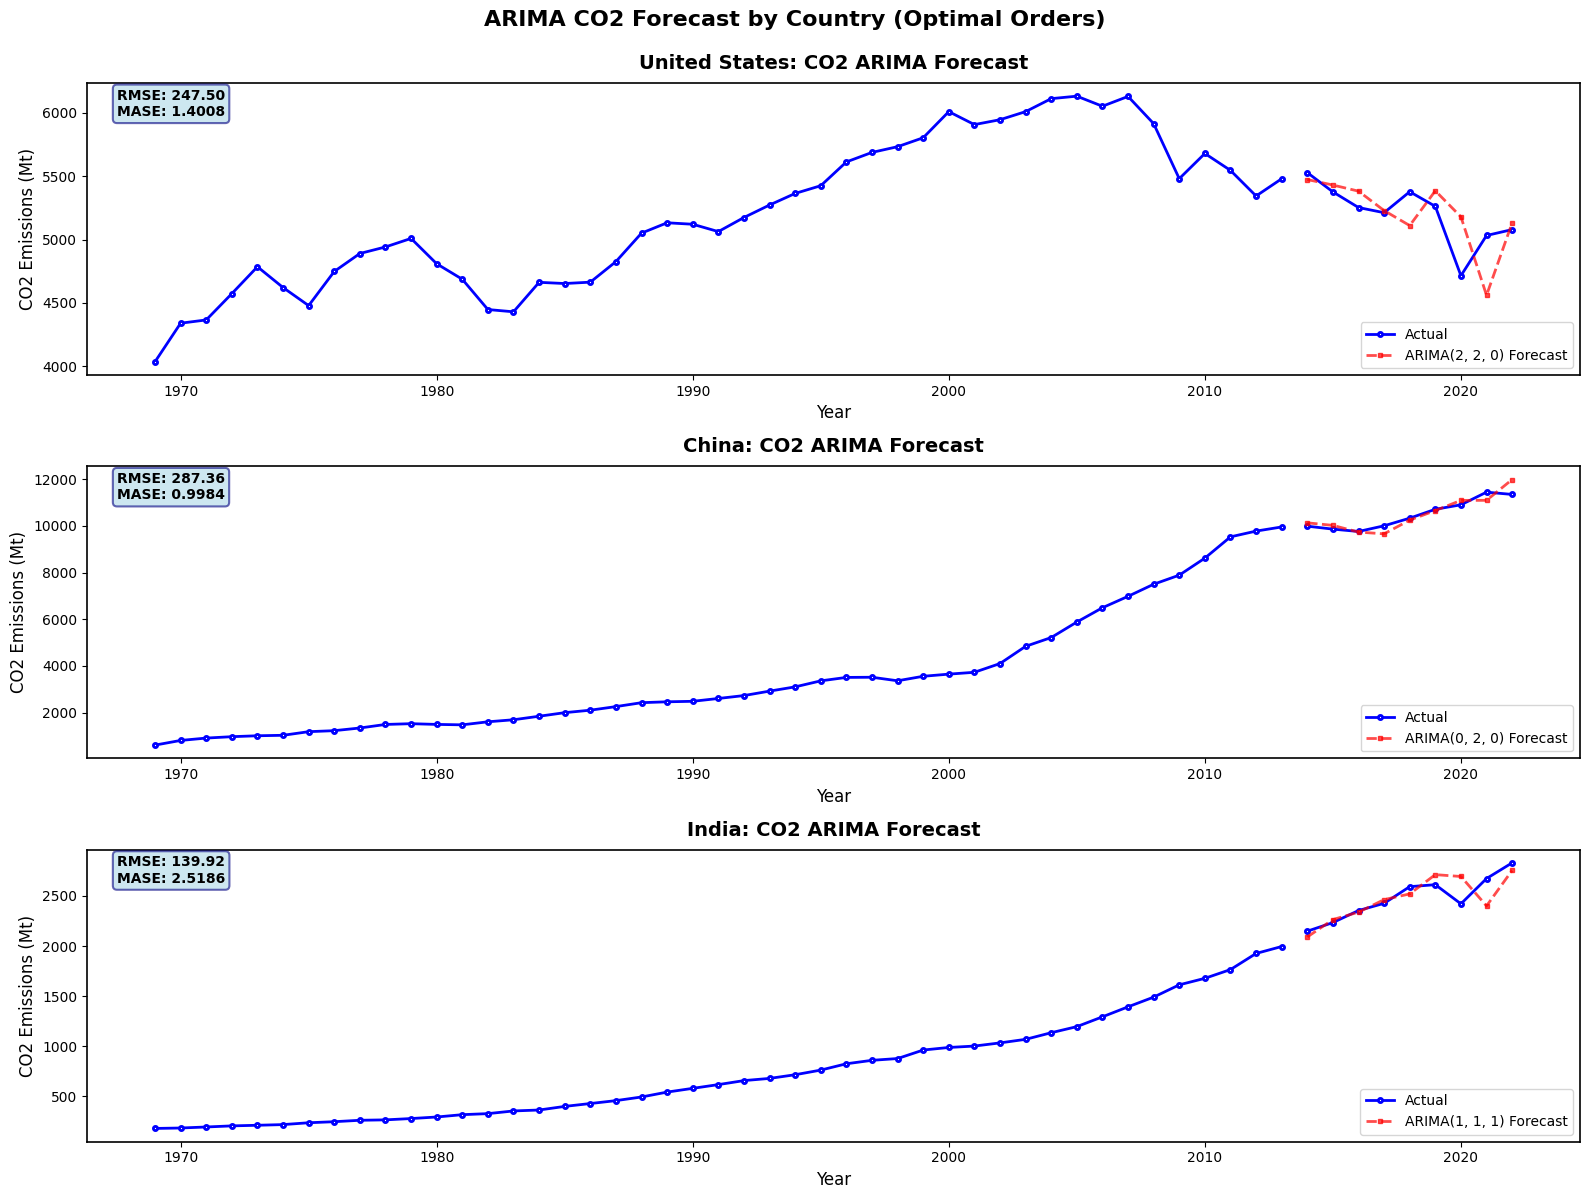

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

colors = {'actual': 'blue', 'forecast': 'red'}

for idx, country in enumerate(SELECTED_COUNTRIES):
    ax = axes[idx]

    train_country = forecasts[country]['train']
    test_country = forecasts[country]['test']
    forecast_values = forecasts[country]['forecast']
    order = results[country]['order']

    # Train
    ax.plot(train_country['year'], train_country[TARGET_VARIABLES], 
            color=colors['actual'], linewidth=2, label='Actual', 
            marker='o', markersize=3, markerfacecolor='white', 
            markeredgewidth=2, markeredgecolor=colors['actual'])
    
    # Test
    ax.plot(test_country['year'], test_country[TARGET_VARIABLES], 
            color=colors['actual'], linewidth=2, 
            marker='o', markersize=3, markerfacecolor='white',
            markeredgewidth=2, markeredgecolor=colors['actual'])
    
    # Forecast
    ax.plot(test_country['year'], forecast_values, 
            color=colors['forecast'], linewidth=2, linestyle='--', 
            label=f'ARIMA{order} Forecast', marker='s', markersize=3,
            markerfacecolor=colors['forecast'], alpha=0.7)
    
    ax.set_title(f'{country}: CO2 ARIMA Forecast', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('CO2 Emissions (Mt)', fontsize=12)
    ax.legend(loc='lower right', fontsize=10, framealpha=0.8)

    metrics = results[country]
    textstr = f"RMSE: {metrics['RMSE']:.2f}\nMASE: {metrics['MASE']:.4f}"
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.6, edgecolor='navy', linewidth=1.5)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props, fontweight='bold')

    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

plt.suptitle('ARIMA CO2 Forecast by Country (Optimal Orders)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

plot_path = os.path.join(save_dir, 'arima_optimal_forecasts.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')

plt.show()